## 16 - Choropleth
>Classic choropleth map. Use color to show data variation across regions. This simple but effective technique is a staple for showing thematic differences. 🎨

In [1]:
import h3
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import Polygon
from shapely.ops import unary_union
import matplotlib.patheffects as path_effects
from matplotlib.colors import LogNorm
ox.settings.max_query_area_size = 6e12

In [2]:
## helper for filling shapely polygon (in lat lon) with h3 hexagons
# returns geodataframe of hexagon 
def fill_poly_with_hexagons(geometry, resolution=5):
    
    x, y = geometry.exterior.coords.xy
    h3_oly = h3.LatLngPoly(list(zip(y,x)))
    h3_hexes = h3.polygon_to_cells(h3_oly, resolution)
    h3_dicts = [h3.cells_to_geo([h]) for h in h3_hexes]
    polygons = [Polygon(h3dict['coordinates'][0]) for h3dict in h3_dicts]
    gdf = gpd.GeoDataFrame({'hex': h3_hexes},
                           geometry=polygons,
                           crs=4326)
    
    return gdf 

In [3]:
# get data
# hungarian border
aoi = ox.geocode_to_gdf('Hungary')
utm_crs = aoi.estimate_utm_crs()
aoi_utm = aoi.to_crs(utm_crs)

# natural springs
springs = (ox.features_from_polygon(aoi.geometry[0],
                                   tags={'natural':'spring'})
           .loc['node'][['geometry']]
           .to_crs(utm_crs))

# cities
cities = (ox.features_from_polygon(aoi.geometry[0],
                                  tags={'capital':['yes', '1', '2', '3', '4', '5', '6']})
          .loc['node'][['geometry','name']]
          .to_crs(utm_crs))

In [4]:
# get h3 hexagons that fill the aoi
gdf = (fill_poly_with_hexagons(aoi.geometry[0],
                              resolution=5)
       .to_crs(utm_crs))


outline = unary_union(gdf.geometry.tolist()).exterior

# count springs/pubs in each hexagon
spring_count = (gpd.sjoin(springs,
                          gdf)
                .groupby('hex')
                .count()
                .drop(columns='index_right')
                .rename(columns={'geometry':'spring_count'}))

gdf = gdf.merge(spring_count,
                left_on='hex',
                right_index=True,
                how='outer'
                )

gdf.loc[gdf['spring_count'].isna(), 'spring_count'] = 0
gdf['spring_count'] += 1

Text(0, -0.1, 'hungarian springs : by:tlohde : © OpenStreetMap contributors')

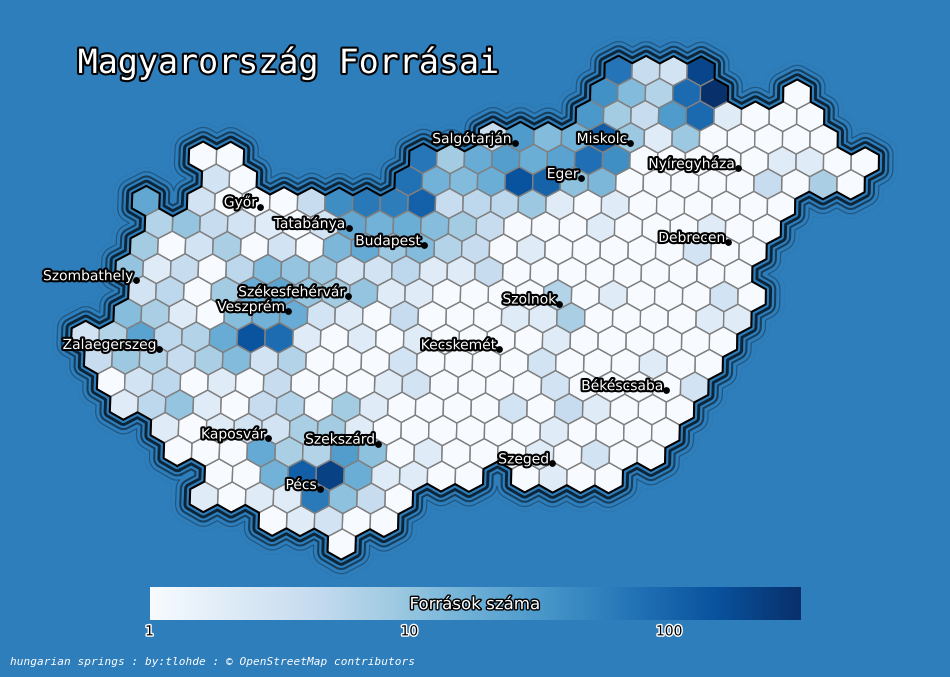

In [ ]:
norm = LogNorm(vmin=1, vmax=gdf['spring_count'].max())
blue = plt.get_cmap('Blues')

fig, ax = plt.subplots(figsize=[12,12],
                       subplot_kw={'aspect':'equal'})

gdf.plot(column='spring_count',
         cmap='Blues',
         ec='gray',
         norm=norm,
         legend=True,
         legend_kwds={'shrink':0.7,
                      'orientation': 'horizontal',
                    #   'label': 'Források száma',
                      'pad': -0.02},
         ax=ax)

ax.plot(*outline.coords.xy, c='k')

for buff, alph in zip([3000, 6000, 9000, 12000],
                      [0.7, 0.5, 0.3, 0.1]):
    ax.plot(*outline.buffer(buff).exterior.coords.xy,
            c='k', alpha=alph, lw=alph*3)
    
cities.plot(c='k',
            marker='o',
            ec='k',
            markersize=15,
            ax=ax, )

for row in cities.itertuples():    
    ax.annotate(
        row.name,
        xy=(row.geometry.x, row.geometry.y),
        xytext=(-2,0),
        textcoords='offset points',
        c='w',
        ha='right',
        path_effects=[path_effects.Stroke(linewidth=3,
                                          foreground='k'),
                      path_effects.Normal()])
    
ax.set_title('Magyarország Forrásai',
            y=0.88, x=0.30, color='w',
            fontdict={'family':'DejaVu Sans Mono',
                    'size':24},
            path_effects=[path_effects.Stroke(linewidth=3,
                                            foreground='k'),
                        path_effects.Normal()])

ax.set_axis_off()
fig.patch.set_facecolor(blue(0.7))

# formatting colorbar
ticks = fig.axes[-1].get_xticks().astype(int)
fig.axes[-1].set_xticks(ticks[1:-2],
                        labels=ticks[1:-2],
                        path_effects=[path_effects.Stroke(linewidth=2,
                                                         foreground='w'),
                                     path_effects.Normal()],)

fig.axes[-1].tick_params(which='both', length=0)

fig.axes[-1].set_title('Források száma', y=0.2, va='center',
                       c='w',
                       path_effects=[path_effects.Stroke(linewidth=2,
                                                         foreground='k'),
                                     path_effects.Normal()])

fig.axes[-1].spines[:].set_visible(False)

# credits
ax.annotate('hungarian springs : by:tlohde : © OpenStreetMap contributors',
            xy=(0, -0.1),
            xycoords='axes fraction',
            font='DejaVu Sans Mono',
            fontstyle='italic',
            color='w',
            fontsize=8)

# fig.savefig('day16.png', dpi=300, bbox_inches='tight')